In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models.scrambler_models_w_diff import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores


Using TensorFlow backend.


In [2]:
#Load tissue-specific model

import keras
import keras.backend as K
from keras.layers import Reshape, Concatenate, Lambda, Conv2D, BatchNormalization, Dense, Activation

def load_pas_network(n_cell_types=1) :

    conv_1 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_1')
    batchnorm_1 = BatchNormalization(axis=-1, name='pasnet_batchnorm_1')
    relu_1 = Activation('relu')

    conv_2 = Conv2D(16, (1, 8), padding='valid', activation='linear', name='pasnet_conv2d_2')
    batchnorm_2 = BatchNormalization(axis=-1, name='pasnet_batchnorm_2')
    relu_2 = Activation('relu')

    max_pool_3 = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')

    def _net_func(sequence_input) :
        
        relu_1_out = relu_1(batchnorm_1(conv_1(sequence_input), training=False))
        relu_2_out = relu_2(batchnorm_2(conv_2(relu_1_out), training=False))

        max_pool_3_out = max_pool_3(relu_2_out)

        final_dense_out = final_dense(max_pool_3_out)
        
        return final_dense_out

    return _net_func

model_name = "human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble"

tissue_type = 'Brain_Frontal_Cortex_BA9'

n_bootstraps = 10

save_dir = '../../../../aparent/saved_models'

pas_models = []

for bootstrap_ix in range(n_bootstraps) :
    
    print("Loading model " + str(bootstrap_ix) + "...")
    
    pas_net = load_pas_network(
        n_cell_types=2
    )
    
    pas_input = Input(shape=(1, 205, 4), name='pas_input')
    
    pas_model = Model([pas_input], [pas_net(pas_input)])
    
    model_path = os.path.join(save_dir, model_name + '_' + str(bootstrap_ix) + '_pas_model' + '.h5')
    pas_model.load_weights(model_path, by_name=True)
    
    pas_models.append(pas_model)

ref_input = Input(name="ref_input", shape=(1, 205, 4))
var_input = Input(name="var_input", shape=(1, 205, 4))

ref_scores = Concatenate(axis=1)([Reshape((1, 2))(pas_models[bootstrap_ix](ref_input)) for bootstrap_ix in range(n_bootstraps)])
var_scores = Concatenate(axis=1)([Reshape((1, 2))(pas_models[bootstrap_ix](var_input)) for bootstrap_ix in range(n_bootstraps)])

mean_ref_scores = Lambda(lambda x: K.mean(x, axis=1))(ref_scores)
mean_var_scores = Lambda(lambda x: K.mean(x, axis=1))(var_scores)

dd_score = Lambda(lambda x: ((x[1][:, 1] - x[1][:, 0]) - (x[0][:, 1] - x[0][:, 0]))[:, None] )([mean_ref_scores, mean_var_scores])
#dd_score = Lambda(lambda x: (x[:, 1] - x[:, 0])[:, None] )(mean_var_scores)

predictor = Model([ref_input, var_input], [dd_score])

predictor.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


Loading model 0...
Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading model 7...
Loading model 8...
Loading model 9...


In [3]:

print(predictor.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ref_input (InputLayer)          (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
var_input (InputLayer)          (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            2754        ref_input[0][0]                  
                                                                 var_input[0][0]                  
__________________________________________________________________________________________________
model_2 (Model)                 (None, 2)            2754        ref_input[0][0]                  
          

In [4]:
#Load variant sequence selection

snp_pred_df = pd.read_csv("../../../../autoscrambler/analysis/apa/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')
snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
snp_pred_df['cut_to_snp'] = np.abs(snp_pred_df['snp_pos'] - 100)
snp_pred_df = snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

snp_pred_df = snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

snp_ids = [
    'chr15_40328292_A_G',
    'chr5_125878908_C_A',
]

df = snp_pred_df.set_index('snp_id').loc[snp_ids].reset_index()

df[['snp_id', 'gene', 'snp_pos', 'effect_size']]


,snp_id,gene,snp_pos,effect_size
0,chr15_40328292_A_G,SRP14,82,0.030866
1,chr5_125878908_C_A,ALDH7A1,103,0.050960


In [5]:
#Generate data feature matrices

#Load data matrices
encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_ref = np.concatenate([encoder(row['wide_seq_ext'][105:105+205])[None, None, ...] for _, row in df.iterrows()], axis=0)
x_var = np.concatenate([encoder(row['wide_seq_ext_var'][105:105+205])[None, None, ...] for _, row in df.iterrows()], axis=0)

b = np.max(x_ref - x_var, axis=-1)[..., None] * 50.


In [6]:
#Define sequence template and background

sequence_template = '$' * 205

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]


In [7]:
#Calculate biased, example-specific backgrounds

pseudo_count = 100.0

x_mean = np.ones((x_ref.shape[0], 205, 4)) * 0.25#(x_ref[:, 0, ...] + pseudo_count) / (1. + 4. * pseudo_count)

group = np.arange(x_mean.shape[0])[:, None]


In [8]:
#Run optimization with bias turned on across CSE, to reduce variance further

cse_bias = np.zeros((1, 1, 205, 1))
cse_bias[:, :, 70:76, :] = 50.


In [19]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 1,
    'n_resblocks_per_group' : 1,
    'n_channels' : 16,
    'window_size' : 3,
    'dilation_rates' : [1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template for k in range(x_ref.shape[0])],
    input_backgrounds=[x_mean[0, :, :] for k in range(x_ref.shape[0])],
    batch_size=1,
    n_samples=128,
    multi_input_mode='shared',
    sample_mode='gumbel',
    gumbel_temp=0.1,
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config,
    subset_size=None
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [20]:
#Round 1: Pre-training

[pwm_ref_pre, pwm_var_pre], [sample_ref_pre, sample_var_pre], [scores_pre, _], pretrain_histories = scrambler.optimize(
    predictor,
    [x_ref, x_var],
    np.zeros((x_ref.shape[0], 1)),
    bias=[b + np.tile(cse_bias, (x_ref.shape[0], 1, 1, 1))],
    group=[group, group],
    batch_size=1,
    n_iters=100,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.5,
    entropy_weight=1.,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars_gtex',
    load_from_cache=False,
)

#Round 2: Fine-tuning

[pwm_ref_fine, pwm_var_fine], [sample_ref_fine, sample_var_fine], [scores_fine, _], finetune_histories = scrambler.optimize(
    predictor,
    [x_ref, x_var],
    np.zeros((x_ref.shape[0], 1)),
    bias=[b + np.tile(cse_bias, (x_ref.shape[0], 1, 1, 1))],
    group=[group, group],
    batch_size=1,
    n_iters=300,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.0,
    entropy_weight=0.5,
    subset_size=None,
    cache_prefix_path='saved_models/apa_vars_gtex',
    load_from_cache=True,
)


Optimizing batch 0...
Epoch 1/1
100/100 [==============================] - 11s 110ms/step - loss: 3.0895e-04 - ft_nll_loss: 2.2352e-04 - ft_entropy_loss: 8.5426e-05
Epoch 1/1
100/100 [==============================] - 6s 63ms/step - loss: 3.0386e-04 - ft_nll_loss: 2.2978e-04 - ft_entropy_loss: 7.4077e-05
Optimizing batch 0...
Epoch 1/1
300/300 [==============================] - 22s 74ms/step - loss: 0.0933 - ft_nll_loss: 8.9173e-05 - ft_entropy_loss: 0.0932
Epoch 1/1
300/300 [==============================] - 18s 59ms/step - loss: 0.0973 - ft_nll_loss: 1.2582e-04 - ft_entropy_loss: 0.0971


In [9]:
#Cache interpretations

save_suffix = '_per_example_inference_mode_brain'
'''
#Store interpretations
pickle.dump({
    'pwm_ref_pre' : pwm_ref_pre,
    'pwm_var_pre' : pwm_var_pre,

    'sample_ref_pre' : sample_ref_pre,
    'sample_var_pre' : sample_var_pre,
    
    'scores_pre' : scores_pre,
    
    'pwm_ref_fine' : pwm_ref_fine,
    'pwm_var_fine' : pwm_var_fine,

    'sample_ref_fine' : sample_ref_fine,
    'sample_var_fine' : sample_var_fine,

    'scores_fine' : scores_fine,
}, open('apaiants_gtex_interpretations' + save_suffix + '.pickle', 'wb'))

'''
#Load interpretations
cache_dict = pickle.load(open('apaiants_gtex_interpretations' + save_suffix + '.pickle', 'rb'))

pwm_ref_pre = cache_dict['pwm_ref_pre']
pwm_var_pre = cache_dict['pwm_var_pre']

sample_ref_pre = cache_dict['sample_ref_pre']
sample_var_pre = cache_dict['sample_var_pre']

scores_pre = cache_dict['scores_pre']

pwm_ref_fine = cache_dict['pwm_ref_fine']
pwm_var_fine = cache_dict['pwm_var_fine']

sample_ref_fine = cache_dict['sample_ref_fine']
sample_var_fine = cache_dict['sample_var_fine']

scores_fine = cache_dict['scores_fine']


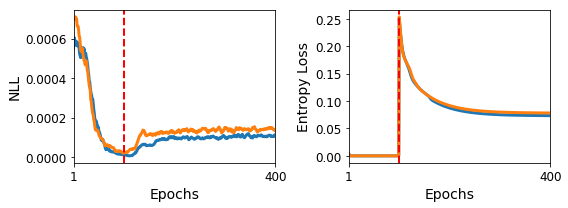

In [22]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(pretrain_histories[0]['ft_nll']) + len(finetune_histories[0]['ft_nll'])

n_epochs_pretrain = len(pretrain_histories[0]['ft_nll'])
n_epochs_finetune = len(finetune_histories[0]['ft_nll'])

nll_rolling_window = 5
entropy_rolling_window = 1

for i in range(len(pretrain_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_nll']), np.array(finetune_histories[i]['ft_nll'])], axis=0), window=nll_rolling_window), linewidth=3)

ax1.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(pretrain_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_entropy']), np.array(finetune_histories[i]['ft_entropy'])], axis=0), window=entropy_rolling_window), linewidth=3)

ax2.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


Sequence 0:
 - Prediction (original) = 0.1450
 - Prediction (scrambled) = 0.1468


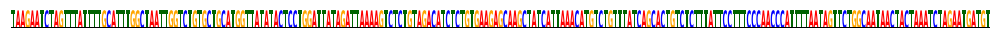

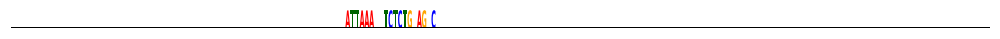

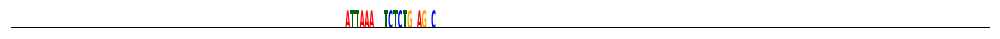

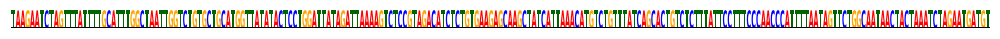

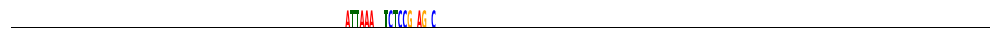

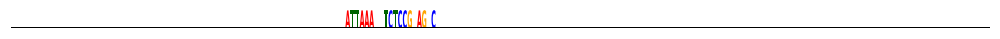

Sequence 1:
 - Prediction (original) = -0.129
 - Prediction (scrambled) = -0.123


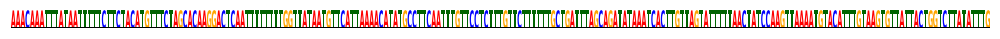

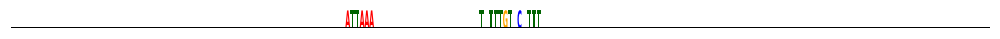

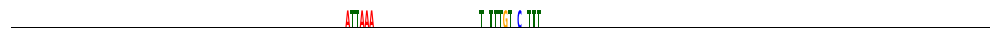

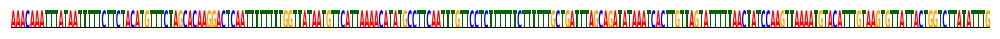

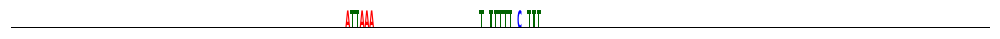

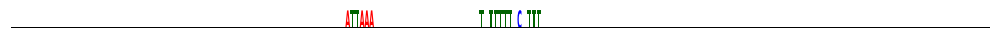

In [24]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_resnet_gtex_finetuned_brain"

pwm_ref_fine_no_bg = (2. * x_ref - 1.) * scores_fine * sequence_mask[None, None, :, None]
pwm_ref_fine_no_bg = np.exp(pwm_ref_fine_no_bg) / np.sum(np.exp(pwm_ref_fine_no_bg), axis=-1)[..., None]

pwm_var_fine_no_bg = (2. * x_var - 1.) * scores_fine * sequence_mask[None, None, :, None]
pwm_var_fine_no_bg = np.exp(pwm_var_fine_no_bg) / np.sum(np.exp(pwm_var_fine_no_bg), axis=-1)[..., None]

save_examples = [0, 1]

q_thresh = 0.95

for plot_i in range(x_ref.shape[0]) :
    
    print("Sequence " + str(plot_i) + ":")
    
    lor = predictor.predict(x=[x_ref[plot_i:plot_i+1], x_var[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_fine = np.mean(predictor.predict(x=[sample_ref_fine[plot_i], sample_var_fine[plot_i]], batch_size=32)[:, 0])
    
    print(" - Prediction (original) = " + str(round(lor, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_fine, 6))[:6])
    
    save_figs = False
    if save_examples is not None and plot_i in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_fine[plot_i, 0, :, 0], q=q_thresh)
    
    plot_dna_logo(x_ref[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref")
    #plot_dna_logo(pwm_ref_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_pwm")
    plot_dna_logo(pwm_ref_fine_no_bg[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_pwm")
    plot_dna_importance_scores(scores_fine[plot_i, 0, :, :].T, encoder.decode(x_ref[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_ref" + "_scores")
    
    plot_dna_logo(x_var[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var")
    #plot_dna_logo(pwm_var_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_pwm")
    plot_dna_logo(pwm_var_fine_no_bg[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_pwm")
    plot_dna_importance_scores(scores_fine[plot_i, 0, :, :].T, encoder.decode(x_var[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_ix_" + str(plot_i) + "_var" + "_scores")


In [10]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
#Load human 3' UTR background distribution (from PolyaDB V3)

x_mean = np.load("../../../../aparent-resnet/analysis/polyadb_v3_utr3_background.npy")

print("x_mean.shape = " + str(x_mean.shape))


x_mean.shape = (205, 4)


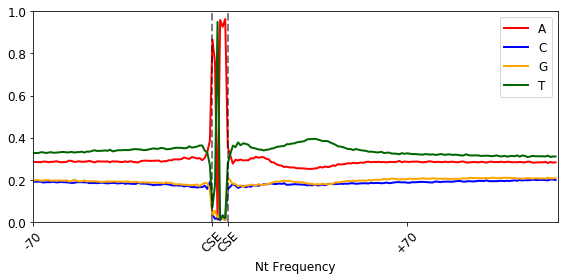

In [12]:
#Plot nt background frequencies across PAS

f = plt.figure(figsize=(8, 4))

l1 = plt.plot(np.arange(205), x_mean[:, 0], color='red', linewidth=2, label='A')
l2 = plt.plot(np.arange(205), x_mean[:, 1], color='blue', linewidth=2, label='C')
l3 = plt.plot(np.arange(205), x_mean[:, 2], color='orange', linewidth=2, label='G')
l4 = plt.plot(np.arange(205), x_mean[:, 3], color='darkgreen', linewidth=2, label='T')

plt.axvline(x=70, color='black', linewidth=2, linestyle='--', alpha=0.5)
plt.axvline(x=76, color='black', linewidth=2, linestyle='--', alpha=0.5)

plt.legend(handles=[l1[0], l2[0], l3[0], l4[0]], fontsize=12)

plt.xticks([0, 70, 76, 146], ['-70', 'CSE', 'CSE', '+70'], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.xlabel("Nt Frequency", fontsize=12)

plt.xlim(0, 205)
plt.ylim(0, 1)

plt.tight_layout()

plt.show()


In [ ]:
#Brain-specific variant interpretation example: rs744722

ix = 1

gene = df.iloc[ix]['gene']
gene_id = df.iloc[ix]['gene_id']
chrom = df.iloc[ix]['chrom']
gene = df.iloc[ix]['gene']
strand = df.iloc[ix]['strand']
var_position = int(df.iloc[ix]['snp_id'].split("_")[1])
rel_var_position = df.iloc[ix]['snp_pos']
pas_pos = df.iloc[ix]['pas_pos']
snp_id = "rs744722"
ref_nucleotide = df.iloc[ix]['snp_ref']
var_nucleotide = df.iloc[ix]['snp_var']
rel_ref_nucleotide = df.iloc[ix]['rel_snp_ref']
rel_var_nucleotide = df.iloc[ix]['rel_snp_var']
data_source = 'aQTL'
experiment = 'brain_specific'

#Get hard mask
score_thresh = 0.5
mask = np.array(scores_fine[ix, 0, :, 0] > score_thresh, dtype=np.int)

no_gaps = True

if no_gaps :    
    for j in range(mask.shape[0]) :
        if (j-1 < 0 or mask[j-1] >= 1) and mask[j] <= 0 and (j+1 > mask.shape[0]-1 or mask[j+1] >= 1) :
            mask[j] = 1

#1. Ref sequence and variant sequence

ref_seq = df.iloc[ix]['wide_seq_ext'][105:105+205]
var_seq = df.iloc[ix]['wide_seq_ext_var'][105:105+205]

#2. Sat mut of masked region (+ padding)

start_pos = 94
end_pos = 113

bases = ['A', 'C', 'G', 'T']

rc_dict = {'A' : 'T', 'C' : 'G', 'G' : 'C', 'T' : 'A'}

mask_mut_seqs = []
mask_mut_var_positions = []
mask_mut_rel_var_positions = []
mask_mut_ref_nucleotides = []
mask_mut_var_nucleotides = []

for j in range(start_pos, end_pos) :
    for nt in bases :
        
        mut_seq = ref_seq[:j] + nt + ref_seq[j+1:]
        
        if mut_seq != ref_seq and mut_seq != var_seq :
            mask_mut_seqs.append(mut_seq)
            mask_mut_rel_var_positions.append(j)
            
            if strand == '+' :
                mask_mut_var_positions.append(j - rel_var_position + var_position)
                mask_mut_ref_nucleotides.append(ref_seq[j])
                mask_mut_var_nucleotides.append(nt)
            else :
                mask_mut_var_positions.append(rel_var_position - j + var_position)
                mask_mut_ref_nucleotides.append(rc_dict[ref_seq[j]])
                mask_mut_var_nucleotides.append(rc_dict[nt])

#3. Sat mut of null region (+ padding)

start_pos = 30
end_pos = 49

bases = ['A', 'C', 'G', 'T']

null_mut_seqs = []
null_mut_var_positions = []
null_mut_rel_var_positions = []
null_mut_ref_nucleotides = []
null_mut_var_nucleotides = []

for j in range(start_pos, end_pos) :
    for nt in bases :
        
        mut_seq = ref_seq[:j] + nt + ref_seq[j+1:]
        
        if mut_seq != ref_seq and mut_seq != var_seq :
            null_mut_seqs.append(mut_seq)
            null_mut_rel_var_positions.append(j)
            
            if strand == '+' :
                null_mut_var_positions.append(j - rel_var_position + var_position)
                null_mut_ref_nucleotides.append(ref_seq[j])
                null_mut_var_nucleotides.append(nt)
            else :
                null_mut_var_positions.append(rel_var_position - j + var_position)
                null_mut_ref_nucleotides.append(rc_dict[ref_seq[j]])
                null_mut_var_nucleotides.append(rc_dict[nt])

#4. Sample from reconstructive PWM (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

mask_pwm_ref_samples = []
mask_pwm_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    for j in range(len(ref_seq)) :
        ref_sample += np.random.choice(bases, p=pwm_ref_fine[ix, 0, j, :] / np.sum(pwm_ref_fine[ix, 0, j, :], axis=-1))
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    mask_pwm_ref_samples.append(ref_sample)
    mask_pwm_var_samples.append(var_sample)

#5. Delete region specified by importance mask (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

mask_delete_ref_samples = []
mask_delete_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ref_seq[:]
    
    #Delete nucleotides specified by importance mask
    for j in range(len(ref_seq)) :
        if mask[j] >= 1 :
            ref_sample = ref_sample[:j] + np.random.choice(bases) + ref_sample[j+1:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    mask_delete_ref_samples.append(ref_sample)
    mask_delete_var_samples.append(var_sample)

#6. Impose mask on dinuc-shuffled background (ref), induce mutation

import random

n_samples = 10

bases = ['A', 'C', 'G', 'T']

mask_dinuc_ref_samples = []
mask_dinuc_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    
    seq_parts = [(ref_seq + "T")[j:j+2] for j in range(0, len((ref_seq + "T")) - 1, 2)]
    random.shuffle(seq_parts)
        
    ref_sample = ("".join(seq_parts))[:205]
        
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    #Insert fixed nucleotides from importance mask
    for j in range(len(ref_seq)) :
        if mask[j] >= 1 :
            ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    mask_dinuc_ref_samples.append(ref_sample)
    mask_dinuc_var_samples.append(var_sample)

#7. Null dinuc-shuffled background (ref), induce mutation

import random

n_samples = 10

bases = ['A', 'C', 'G', 'T']

null_dinuc_ref_samples = []
null_dinuc_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    
    seq_parts = [(ref_seq + "T")[j:j+2] for j in range(0, len((ref_seq + "T")) - 1, 2)]
    random.shuffle(seq_parts)
        
    ref_sample = ("".join(seq_parts))[:205]
        
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    null_dinuc_ref_samples.append(ref_sample)
    null_dinuc_var_samples.append(var_sample)

#8. Impose mask on polyadb background (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

mask_polyadb_ref_samples = []
mask_polyadb_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    for j in range(len(ref_seq)) :
        ref_sample += np.random.choice(bases, p=x_mean[j, :] / np.sum(x_mean[j, :], axis=-1))
    
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    #Insert fixed nucleotides from importance mask
    for j in range(len(ref_seq)) :
        if mask[j] >= 1 :
            ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    mask_polyadb_ref_samples.append(ref_sample)
    mask_polyadb_var_samples.append(var_sample)

#9. Impose mask on polyadb background (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

null_polyadb_ref_samples = []
null_polyadb_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    for j in range(len(ref_seq)) :
        ref_sample += np.random.choice(bases, p=x_mean[j, :] / np.sum(x_mean[j, :], axis=-1))
    
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    null_polyadb_ref_samples.append(ref_sample)
    null_polyadb_var_samples.append(var_sample)

#10. Impose mask on unif background (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

mask_unif_ref_samples = []
mask_unif_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    for j in range(len(ref_seq)) :
        ref_sample += np.random.choice(bases)
    
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    #Insert fixed nucleotides from importance mask
    for j in range(len(ref_seq)) :
        if mask[j] >= 1 :
            ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    mask_unif_ref_samples.append(ref_sample)
    mask_unif_var_samples.append(var_sample)

#11. Impose mask on unif background (ref), induce mutation

n_samples = 10

bases = ['A', 'C', 'G', 'T']

null_unif_ref_samples = []
null_unif_var_samples = []

for sample_ix in range(n_samples) :
    
    ref_sample = ""
    for j in range(len(ref_seq)) :
        ref_sample += np.random.choice(bases)
    
    #Insert fixed sequence region (CSE)
    ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]
    
    ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
    var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]
    
    null_unif_ref_samples.append(ref_sample)
    null_unif_var_samples.append(var_sample)

#Compile variant sequence library

library_df = pd.DataFrame({
    'gene'      : [gene] + [gene] * len(mask_mut_seqs) + [gene] * len(null_mut_seqs) + [gene] * len(mask_pwm_ref_samples) + [gene] * len(mask_delete_ref_samples) + [gene] * len(mask_dinuc_ref_samples) + [gene] * len(null_dinuc_ref_samples) + [gene] * len(mask_polyadb_ref_samples) + [gene] * len(null_polyadb_ref_samples) + [gene] * len(mask_unif_ref_samples) + [gene] * len(null_unif_ref_samples),
    'gene_id'   : [gene_id] + [gene_id] * len(mask_mut_seqs) + [gene_id] * len(null_mut_seqs) + [gene_id] * len(mask_pwm_ref_samples) + [gene_id] * len(mask_delete_ref_samples) + [gene_id] * len(mask_dinuc_ref_samples) + [gene_id] * len(null_dinuc_ref_samples) + [gene_id] * len(mask_polyadb_ref_samples) + [gene_id] * len(null_polyadb_ref_samples) + [gene_id] * len(mask_unif_ref_samples) + [gene_id] * len(null_unif_ref_samples),
    
    'chrom'     : [chrom] + [chrom] * len(mask_mut_seqs) + [chrom] * len(null_mut_seqs) + [chrom] * len(mask_pwm_ref_samples) + [chrom] * len(mask_delete_ref_samples) + [chrom] * len(mask_dinuc_ref_samples) + [chrom] * len(null_dinuc_ref_samples) + [chrom] * len(mask_polyadb_ref_samples) + [chrom] * len(null_polyadb_ref_samples) + [chrom] * len(mask_unif_ref_samples) + [chrom] * len(null_unif_ref_samples),
    'strand'    : [strand] + [strand] * len(mask_mut_seqs) + [strand] * len(null_mut_seqs) + [strand] * len(mask_pwm_ref_samples) + [strand] * len(mask_delete_ref_samples) + [strand] * len(mask_dinuc_ref_samples) + [strand] * len(null_dinuc_ref_samples) + [strand] * len(mask_polyadb_ref_samples) + [strand] * len(null_polyadb_ref_samples) + [strand] * len(mask_unif_ref_samples) + [strand] * len(null_unif_ref_samples),
    'snp_id'    : [snp_id] + [snp_id] * len(mask_mut_seqs) + [snp_id] * len(null_mut_seqs) + [snp_id] * len(mask_pwm_ref_samples) + [snp_id] * len(mask_delete_ref_samples) + [snp_id] * len(mask_dinuc_ref_samples) + [snp_id] * len(null_dinuc_ref_samples) + [snp_id] * len(mask_polyadb_ref_samples) + [snp_id] * len(null_polyadb_ref_samples) + [snp_id] * len(mask_unif_ref_samples) + [snp_id] * len(null_unif_ref_samples),
    
    'data_source' : [data_source] + [data_source] * len(mask_mut_seqs) + [data_source] * len(null_mut_seqs) + [data_source] * len(mask_pwm_ref_samples) + [data_source] * len(mask_delete_ref_samples) + [data_source] * len(mask_dinuc_ref_samples) + [data_source] * len(null_dinuc_ref_samples) + [data_source] * len(mask_polyadb_ref_samples) + [data_source] * len(null_polyadb_ref_samples) + [data_source] * len(mask_unif_ref_samples) + [data_source] * len(null_unif_ref_samples),
    'experiment'  : [experiment + "_variant"] + [experiment + "_mask_mut"] * len(mask_mut_seqs) + [experiment + "_null_mut"] * len(null_mut_seqs) + [experiment + "_mask_pwm"] * len(mask_pwm_ref_samples) + [experiment + "_mask_delete"] * len(mask_delete_ref_samples) + [experiment + "_mask_dinuc"] * len(mask_dinuc_ref_samples) + [experiment + "_null_dinuc"] * len(null_dinuc_ref_samples) + [experiment + "_mask_polyadb"] * len(mask_polyadb_ref_samples) + [experiment + "_null_polyadb"] * len(null_polyadb_ref_samples) + [experiment + "_mask_unif"] * len(mask_unif_ref_samples) + [experiment + "_null_unif"] * len(null_unif_ref_samples),
    
    'pas_pos'           : [pas_pos] + [pas_pos] * len(mask_mut_seqs) + [pas_pos] * len(null_mut_seqs) + [pas_pos] * len(mask_pwm_ref_samples) + [pas_pos] * len(mask_delete_ref_samples) + [pas_pos] * len(mask_dinuc_ref_samples) + [pas_pos] * len(null_dinuc_ref_samples) + [pas_pos] * len(mask_polyadb_ref_samples) + [pas_pos] * len(null_polyadb_ref_samples) + [pas_pos] * len(mask_unif_ref_samples) + [pas_pos] * len(null_unif_ref_samples),
    'pas_pos_hg38'      : [-1] + [-1] * len(mask_mut_seqs) + [-1] * len(null_mut_seqs) + [-1] * len(mask_pwm_ref_samples) + [-1] * len(mask_delete_ref_samples) + [-1] * len(mask_dinuc_ref_samples) + [-1] * len(null_dinuc_ref_samples) + [-1] * len(mask_polyadb_ref_samples) + [-1] * len(null_polyadb_ref_samples) + [-1] * len(mask_unif_ref_samples) + [-1] * len(null_unif_ref_samples),
    'var_position'      : [var_position] + mask_mut_var_positions + null_mut_var_positions + [var_position] * len(mask_pwm_ref_samples) + [var_position] * len(mask_delete_ref_samples) + [var_position] * len(mask_dinuc_ref_samples) + [var_position] * len(null_dinuc_ref_samples) + [var_position] * len(mask_polyadb_ref_samples) + [var_position] * len(null_polyadb_ref_samples) + [var_position] * len(mask_unif_ref_samples) + [var_position] * len(null_unif_ref_samples),
    'var_position_hg38' : [-1] + [-1] * len(mask_mut_seqs) + [-1] * len(null_mut_seqs) + [-1] * len(mask_pwm_ref_samples) + [-1] * len(mask_delete_ref_samples) + [-1] * len(mask_dinuc_ref_samples) + [-1] * len(null_dinuc_ref_samples) + [-1] * len(mask_polyadb_ref_samples) + [-1] * len(null_polyadb_ref_samples) + [-1] * len(mask_unif_ref_samples) + [-1] * len(null_unif_ref_samples),
    'rel_var_position'  : [rel_var_position] + mask_mut_rel_var_positions + null_mut_rel_var_positions + [rel_var_position] * len(mask_pwm_ref_samples) + [rel_var_position] * len(mask_delete_ref_samples) + [rel_var_position] * len(mask_dinuc_ref_samples) + [rel_var_position] * len(null_dinuc_ref_samples) + [rel_var_position] * len(mask_polyadb_ref_samples) + [rel_var_position] * len(null_polyadb_ref_samples) + [rel_var_position] * len(mask_unif_ref_samples) + [rel_var_position] * len(null_unif_ref_samples),
    'ref_nucleotide'    : [ref_nucleotide] + mask_mut_ref_nucleotides + null_mut_ref_nucleotides + [ref_nucleotide] * len(mask_pwm_ref_samples) + [ref_nucleotide] * len(mask_delete_ref_samples) + [ref_nucleotide] * len(mask_dinuc_ref_samples) + [ref_nucleotide] * len(null_dinuc_ref_samples) + [ref_nucleotide] * len(mask_polyadb_ref_samples) + [ref_nucleotide] * len(null_polyadb_ref_samples) + [ref_nucleotide] * len(mask_unif_ref_samples) + [ref_nucleotide] * len(null_unif_ref_samples),
    'var_nucleotide'    : [var_nucleotide] + mask_mut_var_nucleotides + null_mut_var_nucleotides + [var_nucleotide] * len(mask_pwm_ref_samples) + [var_nucleotide] * len(mask_delete_ref_samples) + [var_nucleotide] * len(mask_dinuc_ref_samples) + [var_nucleotide] * len(null_dinuc_ref_samples) + [var_nucleotide] * len(mask_polyadb_ref_samples) + [var_nucleotide] * len(null_polyadb_ref_samples) + [var_nucleotide] * len(mask_unif_ref_samples) + [var_nucleotide] * len(null_unif_ref_samples),
    
    'ref_seq'      : [ref_seq] + [ref_seq] * len(mask_mut_seqs) + [ref_seq] * len(null_mut_seqs) + mask_pwm_ref_samples + mask_delete_ref_samples + mask_dinuc_ref_samples + null_dinuc_ref_samples + mask_polyadb_ref_samples + null_polyadb_ref_samples + mask_unif_ref_samples + null_unif_ref_samples,
    'var_seq'      : [var_seq] + mask_mut_seqs + null_mut_seqs + mask_pwm_var_samples + mask_delete_var_samples + mask_dinuc_var_samples + null_dinuc_var_samples + mask_polyadb_var_samples + null_polyadb_var_samples + mask_unif_var_samples + null_unif_var_samples,
})

#Make variant predictions with APARENT2

encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_ref = np.concatenate([encoder(row['ref_seq'])[None, None, ...] for _, row in library_df.iterrows()], axis=0)
x_var = np.concatenate([encoder(row['var_seq'])[None, None, ...] for _, row in library_df.iterrows()], axis=0)

l_fake = np.zeros((len(library_df), 13))
l_fake[:, 11] = 1.

_, ref_cut_pred = aparent_model.predict(x=[x_ref, l_fake], batch_size=32, verbose=True)
_, var_cut_pred = aparent_model.predict(x=[x_var, l_fake], batch_size=32, verbose=True)

#Calculate isoform logits

isoform_start = 77
isoform_end = 127

ref_iso_pred = np.sum(ref_cut_pred[:, isoform_start:isoform_end], axis=1)
var_iso_pred = np.sum(var_cut_pred[:, isoform_start:isoform_end], axis=1)

delta_logodds_77_127 = np.log(var_iso_pred / (1. - var_iso_pred)) - np.log(ref_iso_pred / (1. - ref_iso_pred))

isoform_start = 0
isoform_end = 205

ref_iso_pred = np.sum(ref_cut_pred[:, isoform_start:isoform_end], axis=1)
var_iso_pred = np.sum(var_cut_pred[:, isoform_start:isoform_end], axis=1)

delta_logodds_0_205 = np.log(var_iso_pred / (1. - var_iso_pred)) - np.log(ref_iso_pred / (1. - ref_iso_pred))

library_df['delta_logodds_77_127'] = delta_logodds_77_127
library_df['delta_logodds_0_205'] = delta_logodds_0_205

#Store dataframe

print("len(library_df) = " + str(len(library_df)))

library_df.to_csv("aqtl_brain_variant_library_20220521.csv", sep='\t', index=False)
